# Delta Function Appeal

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [1]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import pickle

np.random.seed(42)

In [2]:
import os

if os.path.isdir("../notebooks"):
    os.chdir("..")

from utils import viz, delta_function, generate_init


from agent import Person

from model import VirusModel, VirusModel_baseline




## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

Scheduled runs: 5
      race  gender    wealth    health
3238     0       1  0.516869  0.517132
4996     0       0  0.043185  0.471110
2222     0       0  0.221997  0.409673
2851     0       0  0.005398  0.564594
8252     1       0  0.097841  0.239026
...    ...     ...       ...       ...
8961     0       1  0.408232  0.560747
3332     0       1  0.164642  0.893510
7769     0       0  0.514845  0.534818
8674     0       1  0.003374  0.633973
5429     0       1  0.164642  0.814067

[8000 rows x 4 columns]


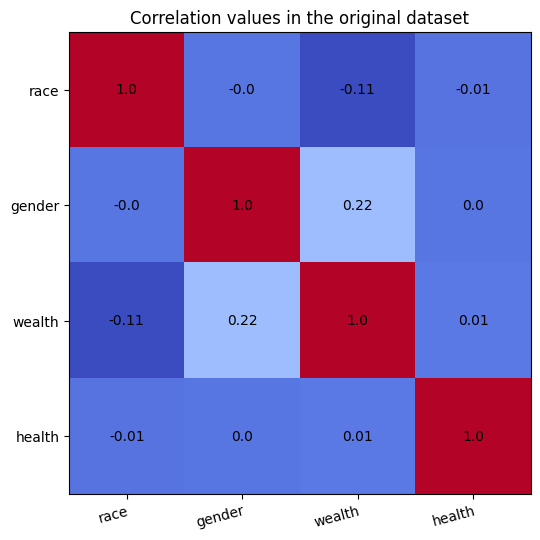

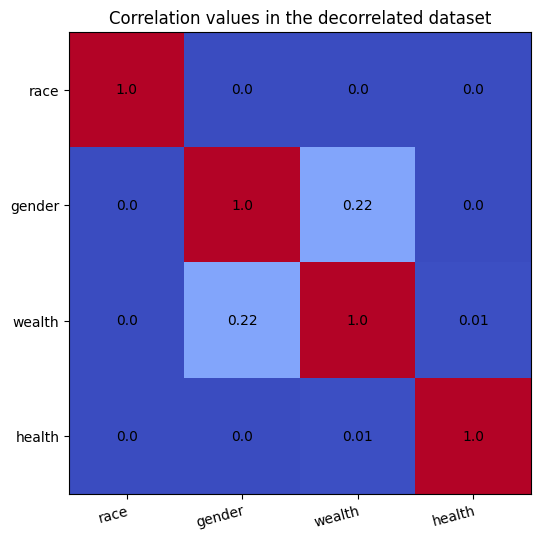

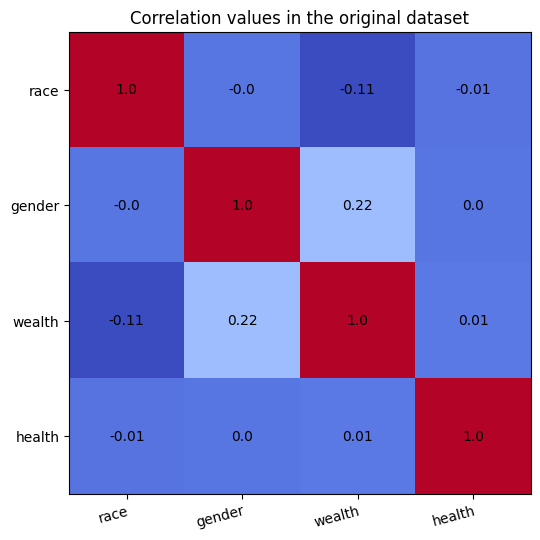

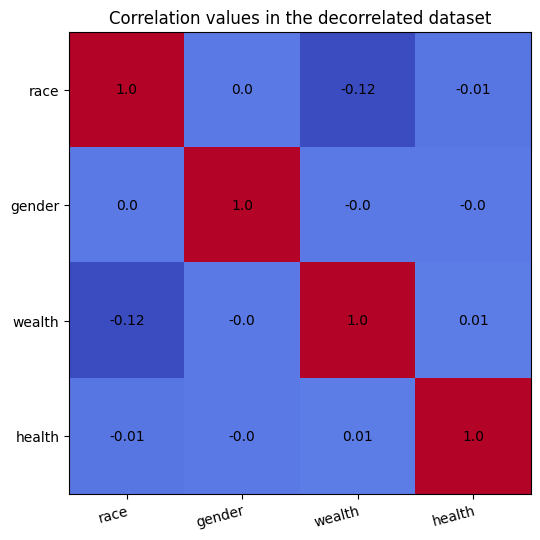

0.589


/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/uni/miniconda

In [3]:
parameters = {
    'my_parameter':42,
    'agents':100,
    'steps':20,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': ap.IntRange(0.25,0.3), # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': 'hist', # None, 'hist'
    'expi': None
    
}
sample = ap.Sample(parameters, n=1)
model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =5, record = True)
results_baseline = exp.run() 

with open("data/expis/fraud_1.pkl", "wb") as f:
        pickle.dump(results_baseline, f)
    
df_baseline = results_baseline['variables']['Person']



In [ ]:
df_baseline['misclassifications'] = (df_baseline['fraud_pred'] - df_baseline['fraud'])
df_baseline[df_baseline['fraud_pred'] ==0]['wealth'].min()

df_baseline.head()
df_baseline = df_baseline[df_baseline.fraud_pred != -1]
df_baseline[df_baseline['misclassifications'] == 0]

wealth  fraud_pred  fraud  race  gender  convicted  \
iteration obj_id t                                                           
0         1      1    0.286444           0      0     0       0          0   
                 2    0.294649           0      0     0       0          0   
                 4    0.312531           0      0     0       0          0   
                 5    0.322299           0      0     0       0          0   
                 6    0.332687           0      0     0       0          0   
...                        ...         ...    ...   ...     ...        ...   
19        500    96   1.000000           0      0     0       1          0   
                 97   1.000000           0      0     0       1          0   
                 98   1.000000           0      0     0       1          0   
                 99   1.000000           0      0     0       1          0   
                 100  1.000000           0      0     0       1          0   

                      eod_gender  eod_race  dpd_gender  dpd_race  \
iteration obj_id t                                                 
0         1      1             0         0           0         0   
                 2             0         0           0         0   
                 4             0         0           0         0   
                 5             0         0           0         0   
                 6             0         0           0         0   
...                          ...       ...         ...       ...   
19        500    96            0         0           0         0   
                 97            0         0           0         0   
                 98            0         0           0         0   
                 99            0         0           0         0   
                 100           0         0           0         0   

                      misclassifications  
iteration obj_id t                        
0         1      1                     0  
                 2                     0  
                 4                     0  
                 5                     0  
                 6                     0  
...                                  ...  
19        500    96                    0  
                 97                    0  
                 98                    0  
                 99                    0  
                 100                   0  

[658819 rows x 11 columns]

In [ ]:
def viz2(data, x, y):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 marker = 'o')
    
    # plt.ylim(0,0.2)
    # plt.xlim(0,50)

    plt.show()

In [ ]:
def viz(data, x, y, hue, title = None):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 hue = hue,
                 marker = 'o')
    
    # plt.ylim(0,0.2)
    # plt.xlim(0,50)
    plt.title(title)

    plt.show()

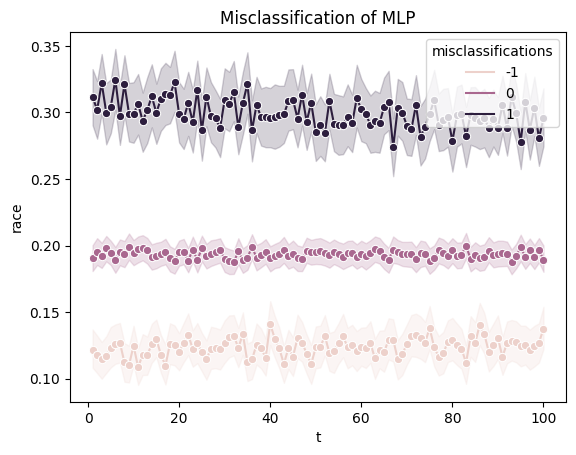

In [ ]:
# viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], df_baseline['fraud_pred'], title= 'MLP Classifier') #, df_baseline['convicted'])

# viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], df_baseline['fraud'], title = 'MLP Classifier') #, df_baseline['convicted'])

# viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['race'], df_baseline['fraud_pred'], title = 'MLP Classifier') #, df_baseline['convicted'])


viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['race'], (df_baseline['misclassifications']), title= 'Misclassification of MLP') #, df_baseline['convicted'])

# viz2(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'])
# viz2(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['fraud'])
# viz2(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['fraud_pred'])





# fig, ax = plt.subplots()

# sns.violinplot(ax = ax,
#                 data = df_baseline,
#                 x = df_baseline.index.get_level_values('t'),
#                 y = df_baseline['wealth'], cut = True)

# # plt.ylim(0,0.2)
# plt.xlim(30, 60)
# # plt.title(title)

# plt.show()

# viz(df_baseline, df_baseline.index.get_level_values('t'), abs(df_baseline['fraud'] - df_baseline['fraud_pred']), df_baseline['race'])#, df_baseline['fraud'])

In [ ]:

# fig, ax = plt.subplots()

# sns.lineplot(ax = ax,
#                 data = df_baseline,
#                 x = df_baseline.index.get_level_values('t'),
#                 y = df_baseline['wealth'],
#                 hue =df_baseline['fraud_pred'],
#                 marker = 'o' )

# sns.lineplot(ax = ax,
#                 data = df_baseline,
#                 x = df_baseline.index.get_level_values('t'),
#                 y = df_baseline['wealth'],
#                 hue =df_baseline['fraud'],
#                 marker = 'x' )

# # plt.ylim(0,0.2)
# plt.xlim(0,10)
# plt.title('title')

In [ ]:
# create baseline value fraud prediction medium income

df_b1 = df_baseline.iloc[(df_baseline['fraud_pred'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

baseline0
df_b0
df_baseline.head(400)
baseline1
# df_x1 = df.iloc[(df_baseline['fraud_pred'] == 1).values] 
# df_wb1 = df_x1['wealth'] - baseline1['wealth']
# df_x1['wealth'] = df_wb1




# df_x0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
# df_wb0 = df_x0['wealth'] - baseline0['wealth']
# df_x0['wealth'] = df_wb0

# df_xb = pd.concat([df_x0, df_x1])

# df_xb

wealth  fraud_pred     fraud      race    gender  convicted  \
t                                                                    
1    0.046260         1.0  0.572768  0.305624  0.433646        1.0   
2    0.023427         1.0  0.578753  0.306138  0.433325        1.0   
3    0.009557         1.0  0.601238  0.307426  0.435149        1.0   
4    0.007580         1.0  0.618684  0.306138  0.433325        1.0   
5    0.004624         1.0  0.615688  0.305624  0.433646        1.0   
..        ...         ...       ...       ...       ...        ...   
96   0.030323         1.0  0.621505  0.298686  0.420072        1.0   
97   0.025595         1.0  0.616863  0.300264  0.422292        1.0   
98   0.022190         1.0  0.605885  0.301254  0.424023        1.0   
99   0.020774         1.0  0.618472  0.302224  0.425048        1.0   
100  0.029642         1.0  0.608228  0.299689  0.420474        1.0   

     eod_gender  eod_race  dpd_gender  dpd_race  misclassifications  
t                                                                    
1           0.0       0.0         0.0       0.0            0.427232  
2           0.0       0.0         0.0       0.0            0.421247  
3           0.0       0.0         0.0       0.0            0.398762  
4           0.0       0.0         0.0       0.0            0.381316  
5           0.0       0.0         0.0       0.0            0.384312  
..          ...       ...         ...       ...                 ...  
96          0.0       0.0         0.0       0.0            0.378495  
97          0.0       0.0         0.0       0.0            0.383137  
98          0.0       0.0         0.0       0.0            0.394115  
99          0.0       0.0         0.0       0.0            0.381528  
100         0.0       0.0         0.0       0.0            0.391772  

[100 rows x 11 columns]

In [ ]:
parameters = {
    'my_parameter':42,
    'agents':500,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.6, # accuracy of fraud prdediction
    'appeal_wealth': 0.3, # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': None, # None, 'hist'
    'expi': None
    
}
sample = ap.Sample(parameters, n=1)
model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =20, record = True)
r_baseline = exp.run() 

with open("data/expis/fraud_1.pkl", "wb") as f:
        pickle.dump(results_baseline, f)
    
df_b = r_baseline['variables']['Person']


Scheduled runs: 20
Completed: 5, estimated time remaining: 0:00:35

KeyboardInterrupt: 

In [ ]:
df_b['misclassifications'] = (df_b['fraud'] - df_b['fraud_pred'])
df_b[df_b['fraud_pred'] ==0]['wealth'].min()

df_b.head()
df_b = df_b[df_b.fraud_pred != -1]
df_b['wealth'] <0.5

iteration  obj_id  t  
0          1       1      True
                   2      True
                   3      True
                   4      True
                   5      True
                          ... 
19         500     96     True
                   97     True
                   98     True
                   99     True
                   100    True
Name: wealth, Length: 1000000, dtype: bool

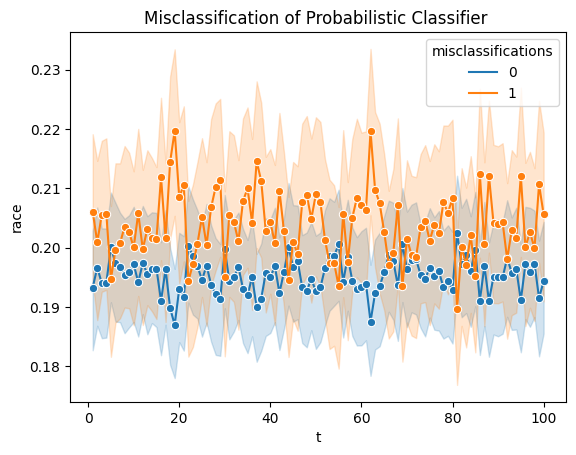

In [ ]:
viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['race'], abs(df_baseline['misclassifications']), title = 'Misclassification of Probabilistic Classifier ') #, df_baseline['convicted'])


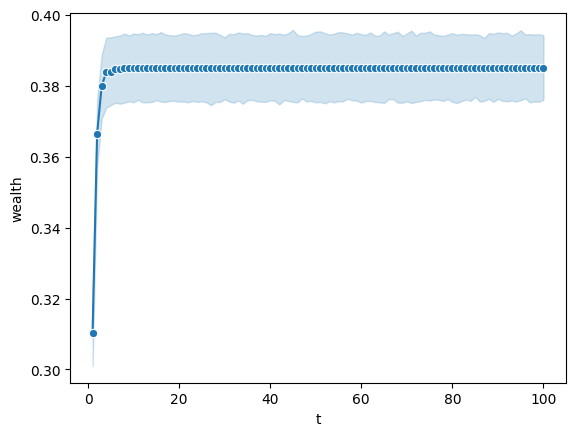

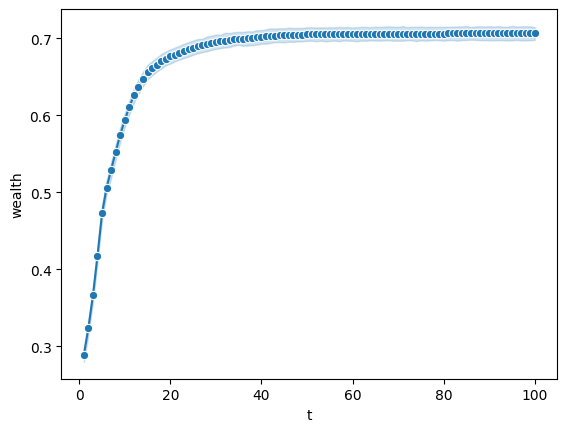

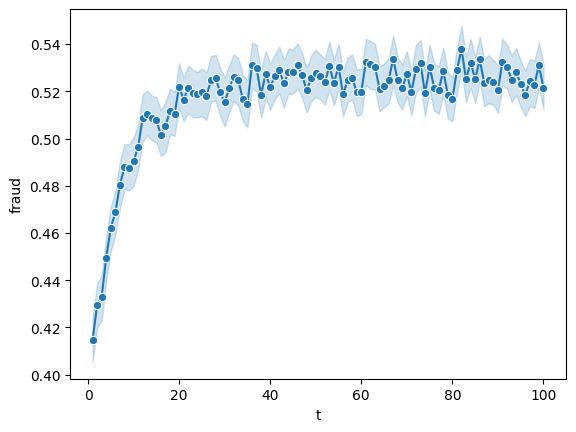

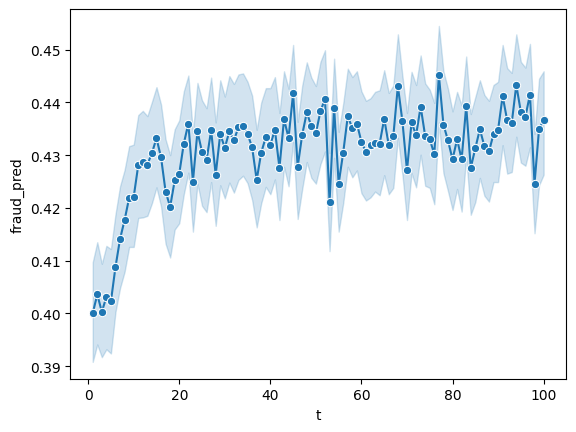

In [ ]:
# viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], abs(df_b['misclassifications']), title = 'Misclassification of Probabilistic Classifier ') #, df_baseline['convicted'])

# viz(df_b, df_b.index.get_level_values('t'), df_b['fraud_pred'], df_b['race'], title= 'Probabilitic Classifier') #, df_baseline['convicted'])

# viz(df_b, df_b.index.get_level_values('t'), df_b['race'], df_b['fraud_pred'], title= 'Probabilitic Classifier') #, df_baseline['convicted'])


# viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud'],title= 'Probabilitic Classifier') #, df_baseline['convicted'])
viz2(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth']<0.1)
viz2(df_b, df_b.index.get_level_values('t'), df_b['wealth']<0.1)
viz2(df_b, df_b.index.get_level_values('t'), df_b['fraud'])
viz2(df_b, df_b.index.get_level_values('t'), df_b['fraud_pred'])

# viz(df_baseline, df_baseline.index.get_level_values('t'), abs(df_baseline['fraud'] - df_baseline['fraud_pred']), df_baseline['race'])#, df_baseline['fraud'])

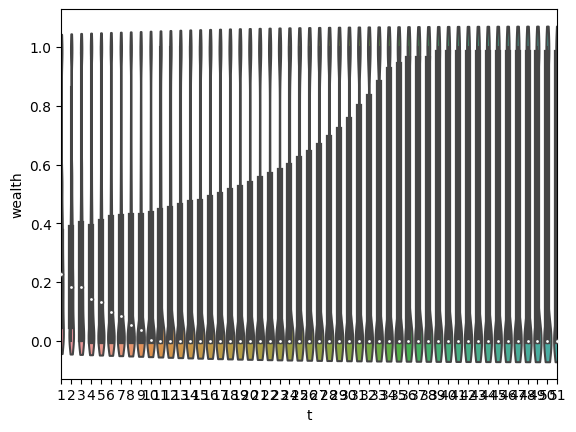

In [ ]:
fig, ax = plt.subplots()

sns.violinplot(ax = ax,
                data = df_b,
                x = df_b.index.get_level_values('t'),
                y = df_b['wealth'], cut = True)

# plt.ylim(0,0.2)
plt.xlim(0,50)
# plt.title(title)

plt.show()

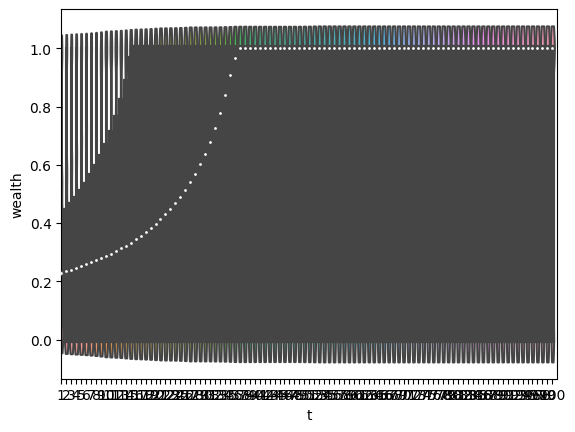

In [ ]:
fig, ax = plt.subplots()

sns.violinplot(ax = ax,
                data = df_baseline,
                x = df_baseline.index.get_level_values('t'),
                y = df_baseline['wealth'], cut = True)

# plt.ylim(0,0.2)
plt.xlim(0,100)
# plt.title(title)

plt.show()

In [ ]:

# fig, ax = plt.subplots()

# sns.lineplot(ax = ax,
#                 data = df_b,
#                 x = df_b.index.get_level_values('t'),
#                 y = df_b['wealth'],
#                 hue =df_b['fraud_pred'],
#                 marker = 'o' )

# sns.lineplot(ax = ax,
#                 data = df_b,
#                 x = df_b.index.get_level_values('t'),
#                 y = df_b['wealth'],
#                 hue =df_b['fraud'],
#                 marker = 'x' )

# # plt.ylim(0,0.2)
# plt.xlim(0,10)
# plt.title('title')

# # viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud_pred']) #, df_baseline['convicted'])

# # viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud']) #, df_baseline['convicted'])